In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from IPython import display
import imageio
import glob

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
train_images = np.reshape(train_images, (len(train_images), 28, 28, 1))
train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5

In [13]:
def generator_model():
  model = tf.keras.Sequential()

  model.add(layers.Dense(7*7*128, input_shape=(100,)))
  model.add(layers.Reshape((7, 7, 128)))

  model.add(layers.Conv2DTranspose(64, kernel_size=3, strides=(2, 2), padding='same'))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.LeakyReLU(0.2))

  model.add(layers.Conv2DTranspose(32, kernel_size=3, strides=(1, 1), padding='same'))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.LeakyReLU(0.2))

  model.add(layers.Conv2DTranspose(1, kernel_size=3, strides=(2, 2), padding='same', activation='tanh'))

  return model

generator = generator_model()
# print(generator.summary())

In [14]:
def discriminator_model():
  model = tf.keras.Sequential()

  model.add(layers.Conv2D(32, kernel_size=3, strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
  model.add(layers.LeakyReLU(0.2))

  model.add(layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.LeakyReLU(0.2))

  model.add(layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.LeakyReLU(0.2))

  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))

  return model

discriminator = discriminator_model()
# print(discriminator.summary())

In [15]:
num_of_images_to_generate = 16
noise_dim = 100

test_input = tf.random.normal([num_of_images_to_generate, noise_dim])

def generate_and_save_images(epoch):
  predictions = generator(test_input, training=False)
  
  fig = plt.figure(figsize=(4, 4))
  
  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
    
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

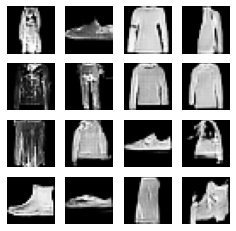

Epoch 50


In [16]:
epochs = 50
batch_size = 64

dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(batch_size)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

for epoch in range(epochs):
  for data in dataset:
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
      generated_images = generator(noise, training=True)
      real_output = discriminator(data, training=True)
      fake_output = discriminator(generated_images, training=True)
      
      generator_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
      
      real_loss = cross_entropy(tf.ones_like(real_output), real_output)
      fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
      discriminator_loss = real_loss + fake_loss
    
    gradients_of_generator = generator_tape.gradient(generator_loss, generator.trainable_variables)
    gradients_of_discriminator = discriminator_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
  display.clear_output(wait=True)
  generate_and_save_images(epoch + 1)
  print('Epoch', epoch + 1)

In [17]:
with imageio.get_writer('dcgan.gif', mode='I') as writer:
  filenames = sorted(glob.glob('image*.png'))
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)